In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import scipy
from scipy.cluster import hierarchy as hc

This notebook tries to answer the following questions:

1. How satisfied are developers currently within their jobs?
2. What are the factors that influence job satisfaction the most?
3. Building on this, what should be considered to increase job satisfaction?

As data basis Stack Overflow’s annual Developer Survey of 2019 was taken to start with that analysis (https://insights.stackoverflow.com/survey/2019).

In [3]:
# used functionality throughout the notebook

def mad(x,y): return sum(abs(x-y))/len(x)

def handle_multi_string_columns(df, column, single_strings):
    '''
    Replaces column whose fields contain several strings with new columns. Each
    new column will then represent a single string
    
    INPUT:
    df - the pandas dataframe you want to search
    column - the column name you want to look through
    single_strings - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - The dataframe without the multi-string column but with the newly created columns
    col_dict - Dictionary translating names of the new columns to their corresponding string
    '''
    
    #collects new columns of indicating if a certain index refers to a string 
    new_columns = dict()
    
    #dict column name -> string name
    col_dict = dict()
    
    #loop through list of strings
    counter = 0
    for string in single_strings:
        bool_list = []
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row set to True
            if string in str(df[column][idx]):
                bool_list.append(1)
            else:
                bool_list.append(0)
        col_name = column + "_" + str(counter)
        new_columns[col_name] = bool_list
        col_dict[col_name] = string
        counter = counter + 1
    
    new_df = df.drop(column,axis=1)
    
    new_df = pd.concat([new_df, pd.DataFrame(data=new_columns, index = df.index, dtype=int)], axis=1)
    
    return new_df, col_dict


def rf_feat_importance(m, X_test, y_test_preds):
    cor = []
    for name, col in X_test.iteritems():
        cor.append(scipy.stats.spearmanr(col,np.round(y_test_preds + corrector)).correlation)
    return pd.DataFrame({'cols':X_test.columns, 'imp':m.feature_importances_, 'corr': cor}).sort_values('imp', ascending=False)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def mean_absolute_error_2(y_true, y_pred):
    return mean_absolute_error(y_true, np.round(y_pred))


def classification(y_train, y_test_preds):
    y_train_min = np.min(y_train)
    y_train_max = np.max(y_train)
    total_distance = y_train_max - y_train_min
    point_0 = y_train_min + total_distance * np.sum(y_train == 0) / len(y_train)
    point_1 = point_0 + total_distance * np.sum(y_train == 1) / len(y_train)
    point_2 = point_1 + total_distance * np.sum(y_train == 2) / len(y_train)
    point_3 = point_2 + total_distance * np.sum(y_train == 3) / len(y_train)
    point_4 = y_train_max
    
    for i in range(len(y_test_preds)):
        if y_test_preds[i] <= point_0:
            y_test_preds[i] = 0
        elif y_test_preds[i] <= point_1:
            y_test_preds[i] = 1
        elif y_test_preds[i] <= point_2:
            y_test_preds[i] = 2
        elif y_test_preds[i] <= point_3:
            y_test_preds[i] = 3
        elif y_test_preds[i] <= point_4:
            y_test_preds[i] = 4
        else:
            print("An error occurred!")
            break
    
        return y_test_preds

In [4]:
# Read in the data set and the schema of Stack Overflow’s annual Developer Survey
# https://insights.stackoverflow.com/survey
df_raw = pd.read_csv('./developer_survey_2019/survey_results_public.csv', low_memory=False)
schema = pd.read_csv('./developer_survey_2019/survey_results_schema.csv')

In [30]:
df_raw.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


Analyzing the schema of the data and the questions that were asked in the survey (https://insights.stackoverflow.com/survey) many columns are not particulary interesting for the planned analysis, since they do not bring much more insight about job satisfaction, leak somehow information of our target like respondent id (Respondent) or if a person is currently looking for a job (JobSeek). Also, I am particularly interested in at least part-time employees. I also removed students, with the hope to get a more accurate model (since there are enough data points).

In [11]:
# Since I am interested in employee's job satisfaction I removed irrelevant and misleading features and rows 
df = df_raw.dropna(subset=['JobSat'], axis=0)
df = df[df.Employment.isin(['Employed full-time', 'Employed part-time'])]
df = df[df.Student == 'No']
df = df.drop(['Respondent','ResumeUpdate','CurrencySymbol','CurrencyDesc','CompTotal','SurveyEase','SurveyLength','SONewContent','WelcomeChange','SOComm','EntTeams','SOVisit1st',
                 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime', 'SOAccount','SOPartFreq', 'SOJobs', 'LanguageWorkedWith', 'LanguageDesireNextYear',
                 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear', 'MiscTechWorkedWith', 
                 'MiscTechDesireNextYear', 'DevEnviron','Student','Ethnicity','JobSeek'], axis=1)

# The remaining data points are quite complete, nevertheless I dropped even further (the remaining data points are anyways more than enough)
df = df.dropna(thresh=45)
df = df.reset_index(drop=True)

In [12]:
# Some qeustions of the survey allowed multiple answers and the answers were then concatenated as a string.
# At least for the following 5 columns I introduced new columns, for each answer possibility one row, which are 1 if 
# the answer was chosen, 0 otherwise.
EduOther_strings = ['Taken an online course in programming or software development (e.g. a MOOC)','Participated in a fulltime developer training program or bootcamp',
                    'Taken a part-time in-person course in programming or software development','Completed an industry certification program (e.g. MCPD)',
                    'Received on-the-job training in software development','Taught yourself a new language, framework, or tool without taking a formal course',
                    'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)','Participated in a hackathon','Contributed to open source software',
                    'None of these']

DevType_strings = ['Academic researcher','Data or business analyst','Data scientist or machine learning specialist','Database administrator','Designer','Developer, back-end',
                   'Developer, desktop or enterprise applications','Developer, embedded applications or devices','Developer, front-end','Developer, full-stack',
                   'Developer, game or graphics','Developer, mobile','Developer, QA or test','DevOps specialist','Educator','Engineer, data','Engineer, site reliability',
                   'Engineering manager','Marketing or sales professional','Product manager','Scientist',"Senior Executive (C-Suite, VP, etc.)", 'Student', 'System administrator']

LastInt_strings = ['Write any code','Write code by hand (e.g., on a whiteboard)','Complete a take-home project','Solve a brain-teaser style puzzle','Interview with people in peer roles',
                   'Interview with people in senior / management roles']

WorkChallenge_strings = ['Distracting work environment','Being tasked with non-development work','Meetings','Time spent commuting','Not enough people for the workload',
                         'Toxic work environment','Inadequate access to necessary tools','Lack of support from management','Non-work commitments (parenting, school work, hobbies, etc.)']

JobFactors_strings = ['Diversity of the company or organization',"Languages, frameworks, and other technologies I'd be working with","Industry that I'd be working in",
                      'How widely used or impactful my work output would be',"Specific department or team I'd be working on",'Flex time or a flexible schedule',
                      'Remote work options','Financial performance or funding status of the company or organization','Office environment or company culture',
                      'Opportunities for professional development']

df, dict_EduOther = handle_multi_string_columns(df,"EduOther",EduOther_strings)
df, dict_DevType = handle_multi_string_columns(df,"DevType",DevType_strings)
df, dict_LastInt = handle_multi_string_columns(df,"LastInt",LastInt_strings)
df, dict_WorkChallenge = handle_multi_string_columns(df,"WorkChallenge",WorkChallenge_strings)
df, dict_JobFactors = handle_multi_string_columns(df,"JobFactors",JobFactors_strings)

In [15]:
df.head()

,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,EdLevel,UndergradMajor,OrgSize,YearsCode,...,JobFactors_0,JobFactors_1,JobFactors_2,JobFactors_3,JobFactors_4,JobFactors_5,JobFactors_6,JobFactors_7,JobFactors_8,JobFactors_9
0,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,100 to 499 employees,3,...,0,1,0,0,0,1,1,0,0,0
1,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,3,...,0,1,0,0,0,0,0,0,1,1
2,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","10,000 or more employees",16,...,0,1,1,0,0,1,0,0,0,0
3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Canada,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,NaN,13,...,0,0,0,1,0,0,0,1,0,1
4,I am a developer by profession,Yes,Once a month or more often,The quality of OSS and closed source software ...,Employed full-time,New Zealand,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",10 to 19 employees,12,...,0,0,0,1,0,0,0,1,1,0


Our target variable is JobSat. Unfortunately, it is wrongly orderd which has to be corrected. I also converted all string type columns to catecoricals. In addition, I corrected some orders in a more meaningful way.

In [16]:
# Converting the columns to categoricals
for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

df.JobSat.cat.set_categories(['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied', 'Very satisfied'], ordered=True, inplace=True)
df.CareerSat.cat.set_categories(['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied', 'Very satisfied'], ordered=True, inplace=True)
df.PurchaseHow.cat.set_categories(['The CTO, CIO, or other management purchase new technology typically without the involvement of developers','Not sure',
                                   'Developers and management have nearly equal input into purchasing new technology','Developers typically have the most influence on purchasing new technology'],
                                 ordered=True, inplace=True)
#df.JobSeek.cat.set_categories(['I am not interested in new job opportunities','I’m not actively looking, but I am open to new opportunities','I am actively looking for a job'], ordered=True, inplace=True)

Lets see how satisfied are the remaining 49681 participants of the survey?

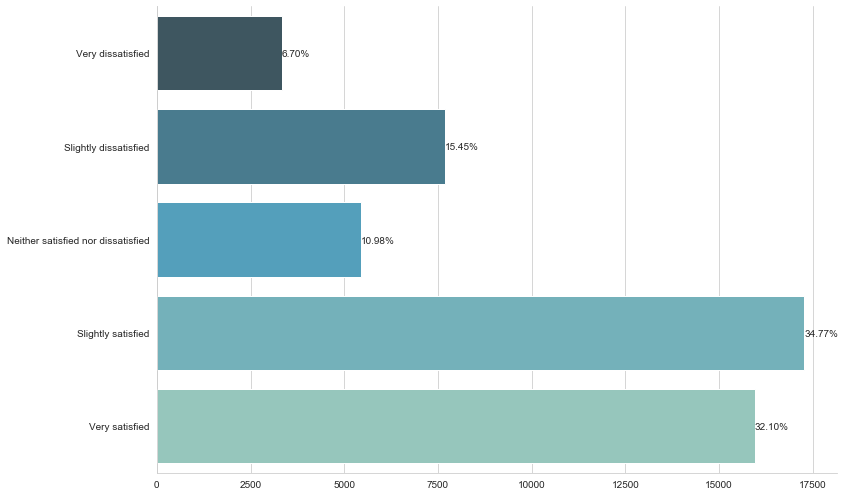

In [17]:
# Bar chart of job satisfaction of the remaining participance
sns.set_style("whitegrid")
g = sns.catplot(y="JobSat", kind="count", data=df,palette='GnBu_d',height=7, aspect=12/7)
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
#g.savefig("output.png",dpi=400)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_width()/len(df)), xy=(p.get_x() + p.get_width(),0.035 + p.get_y() + p.get_height()/2))

#g.savefig("output.png",dpi=800)

Since I am going to use a random forest I have to enumerate all categorical variables. I also used one hot encoding and replaced missing values by the mean. I also tried median and mode, but the mean gave the best results.

In [18]:
# Applying one hot encoding
df_indicator = df.isnull().astype(int).add_suffix('_nan')
df = pd.concat([df, df_indicator], axis=1)

In [20]:
df.head()

,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,EdLevel,UndergradMajor,OrgSize,YearsCode,...,JobFactors_0_nan,JobFactors_1_nan,JobFactors_2_nan,JobFactors_3_nan,JobFactors_4_nan,JobFactors_5_nan,JobFactors_6_nan,JobFactors_7_nan,JobFactors_8_nan,JobFactors_9_nan
0,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,100 to 499 employees,3,...,0,0,0,0,0,0,0,0,0,0
1,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,3,...,0,0,0,0,0,0,0,0,0,0
2,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","10,000 or more employees",16,...,0,0,0,0,0,0,0,0,0,0
3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Canada,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,NaN,13,...,0,0,0,0,0,0,0,0,0,0
4,I am a developer by profession,Yes,Once a month or more often,The quality of OSS and closed source software ...,Employed full-time,New Zealand,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",10 to 19 employees,12,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Numerizing catecorical columns
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
df = df.apply(fill_mean, axis=0)

In [22]:
#Drop columns with all NaN values
df = df.dropna(how='all', axis=0)
df = df.dropna(how='all', axis=1)
#delete columns that add up to 0
df = df.loc[:, (df != 0).any(axis=0)]

In [23]:
# Produce a training, test and validation set
X = df.drop(['JobSat','CareerSat'], axis=1)
y = df['JobSat']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.25, random_state=42)

In [33]:
y_train.head()

13852    3
6363     3
40499    4
31858    1
38930    4
Name: JobSat, dtype: int8

In [24]:
# Grid search for good parameters, I used the mean absolute error as the main measure of quality
param_grid = {'min_samples_leaf': [10,15,20],'max_depth': [20,30,40]}
grid = GridSearchCV(RandomForestRegressor(n_estimators=100,n_jobs=-1, oob_score=True), param_grid=param_grid,
                    scoring='neg_mean_absolute_error',cv=5, return_train_score=True)
X_train_grit = X_train.sample(frac=0.5, random_state=42)
grid.fit(X_train_grit, y_train.loc[X_train_grit.index])
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: -0.893
best parameters: {'max_depth': 40, 'min_samples_leaf': 15}
test-set score: -0.902


In this notebook I used one model, a random forest, to predict job satisfaction. I also tried different approaches to deal with this ordinal regression (multi-model gradient boosting (also in the repo), linear regression etc.). At the end the more complex models did not give much better results and are much more difficult to get insights out of them. Therefore, I used a simple random regressor to procceed, which yields to quite good results.

In [31]:
# Out of performance reasons I used mean squared error, which is equal to variance reduction as feature selection criterion
model_rf = RandomForestRegressor(n_estimators=200, n_jobs=-1,oob_score=True, min_samples_leaf=grid.best_params_['min_samples_leaf'], max_depth=grid.best_params_['max_depth'])
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [32]:
#Predict using your model
y_test_preds = model_rf.predict(X_test)
y_train_preds =model_rf.predict(X_train)
#Score using your model
test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)
# train_mad = mad(y_train, classification(y_train, y_train_preds))
# test_mad = mad(y_test, classification(y_train, y_test_preds))

# Here a correction factor is used for converting to integer prediction
corrector = 0 
train_mad = 1
for i in range(-10, 10):
    new_mad = mad(y_train, np.round(y_train_preds + i/10))
    if new_mad < train_mad:
        train_mad = new_mad
        corrector = i / 10 

test_mad = mad(y_test, np.round(y_test_preds + corrector))

print("The rsquared on the training data is {}.  The rsquared on the test data is {}.".format(train_r2, test_r2))
print("The mad on the training data is {}.  The mad on the test data is {}.".format(train_mad, test_mad))

The rsquared on the training data is 0.45241900323631334.  The rsquared on the test data is 0.22374705799809458.
The mad on the training data is 0.6599570585077832.  The mad on the test data is 0.8418679549114332.


In [34]:
# The mean absolute deviation or mean absolute error is used to measure the reliability of the model. It is far below
# 1 which implicates that the predictions deviate not much from their real value.
y_valid_preds =model_rf.predict(X_valid)
valid_mad = mad(y_valid, np.round(y_valid_preds + corrector))
print("The mad on the validation data is {}.".format(valid_mad))

The mad on the validation data is 0.8444945267224726.


Since the mean absolute error (or mean absolute deviation mad) is quite below 1 also for the validation set, I assume that the predictions are quite well. It basically means that on average the predictions don't even differ by 1. In the following, I take a closer look at the feature importance and also removed "unimportant" features.

In [35]:
# The following table shows the feature importance and the correlation with the prediction
fi = rf_feat_importance(model_rf, X_test, y_test_preds); fi

,cols,imp,corr
12,MgrIdiot,0.284948,0.557553
27,PurchaseHow,0.065634,0.351352
18,ConvertedComp,0.059901,0.228159
86,WorkChallenge_5,0.033085,-0.269869
88,WorkChallenge_7,0.032746,-0.369377
5,Country,0.025692,0.195312
9,YearsCode,0.023709,0.007346
39,Age,0.023423,0.005161
11,YearsCodePro,0.020679,0.002249
10,Age1stCode,0.019863,-0.045347


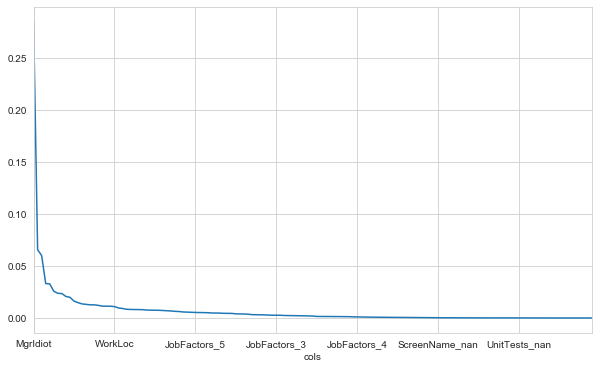

In [36]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

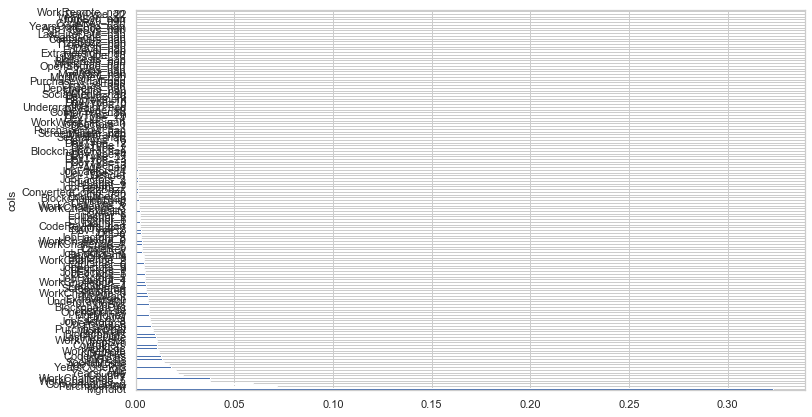

In [358]:
plot_fi(fi);

In [37]:
# To get a better reliability of the feature importance I removed rather unimportant features
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

21

In [38]:
X = X[to_keep]
y = df['JobSat']
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.25, random_state=42)

In [39]:
param_grid = {'min_samples_leaf': [10,15,20],'max_depth': [20,30,40]}
grid = GridSearchCV(RandomForestRegressor(n_estimators=100,n_jobs=-1, oob_score=True), param_grid=param_grid,
                    scoring='neg_mean_absolute_error',cv=5, return_train_score=True)
X_train_grit = X_train.sample(frac=0.5, random_state=42)
grid.fit(X_train_grit, y_train.loc[X_train_grit.index])
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: -0.897
best parameters: {'max_depth': 30, 'min_samples_leaf': 20}
test-set score: -0.905


In [40]:
model_rf = RandomForestRegressor(n_estimators=200, n_jobs=-1,oob_score=True, min_samples_leaf=grid.best_params_['min_samples_leaf'], max_depth=grid.best_params_['max_depth'])
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [41]:
#Predict using your model
y_test_preds = model_rf.predict(X_test)
y_train_preds =model_rf.predict(X_train)
#Score using your model
test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)
# train_mad = mad(y_train, classification(y_train, y_train_preds))
# test_mad = mad(y_test, classification(y_train, y_test_preds))

corrector = 0 
train_mad = 1
for i in range(-10, 10):
    new_mad = mad(y_train, np.round(y_train_preds + i/10))
    if new_mad < train_mad:
        train_mad = new_mad
        corrector = i / 10 

test_mad = mad(y_test, np.round(y_test_preds + corrector))

print("The rsquared on the training data is {}.  The rsquared on the test data is {}.".format(train_r2, test_r2))
print("The mad on the training data is {}.  The mad on the test data is {}.".format(train_mad, test_mad))

The rsquared on the training data is 0.3680061028049908.  The rsquared on the test data is 0.2141329534099038.
The mad on the training data is 0.7265700483091787.  The mad on the test data is 0.8459473966720343.


In [42]:
# Good news the outcome is nearly the same as before
y_valid_preds =model_rf.predict(X_valid)
valid_mad = mad(y_valid, np.round(y_valid_preds + corrector))
print("The mad on the validation data is {}.".format(valid_mad))

The mad on the validation data is 0.8547971667739859.


I removed more that 120 features and just keep 20. The result is nearly the same but the model much easier and the feature analysis hopefully more precise.

In [43]:
fi = rf_feat_importance(model_rf, X_test, y_test_preds); fi

,cols,imp,corr
0,MgrIdiot,0.350682,0.555706
2,ConvertedComp,0.088122,0.237035
1,PurchaseHow,0.085459,0.360600
3,WorkChallenge_5,0.041399,-0.278810
5,Country,0.039538,0.187539
4,WorkChallenge_7,0.039253,-0.368144
7,Age,0.036921,0.009273
6,YearsCode,0.035847,0.003010
9,Age1stCode,0.030783,-0.039806
8,YearsCodePro,0.030402,0.011880


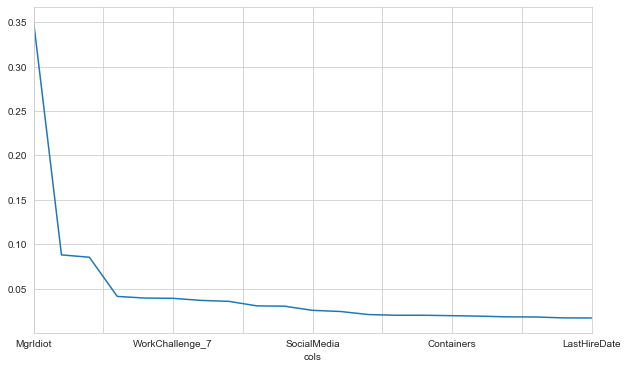

In [44]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

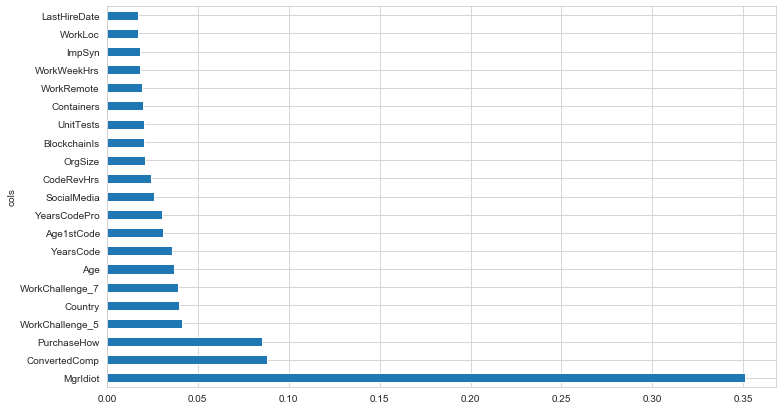

In [45]:
plot = plot_fi(fi)
fig = plot.get_figure()
fig.savefig("feature_importance.png",dpi=800)

Lets take a look at the schema and at the 3 most important features:

1. MgrIdiot,How confident are you that your manager knows what they’re doing?
2. ConvertedComp,"Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks."
3. PurchaseHow,"How does your company make decisions about purchasing new technology (cloud, AI, IoT, databases)?"

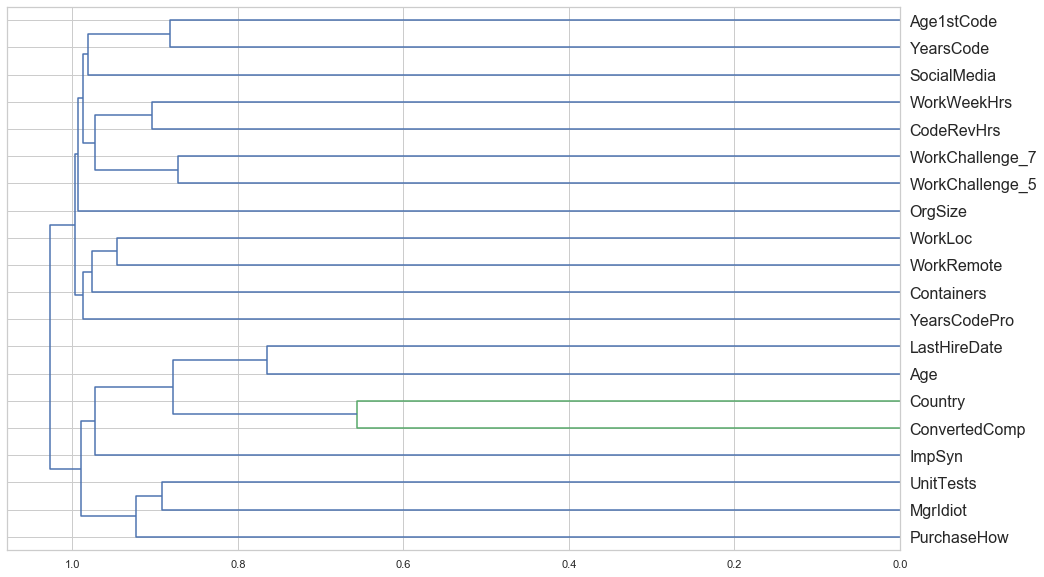

In [368]:
corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X.columns, orientation='left', leaf_font_size=16)
plt.show()

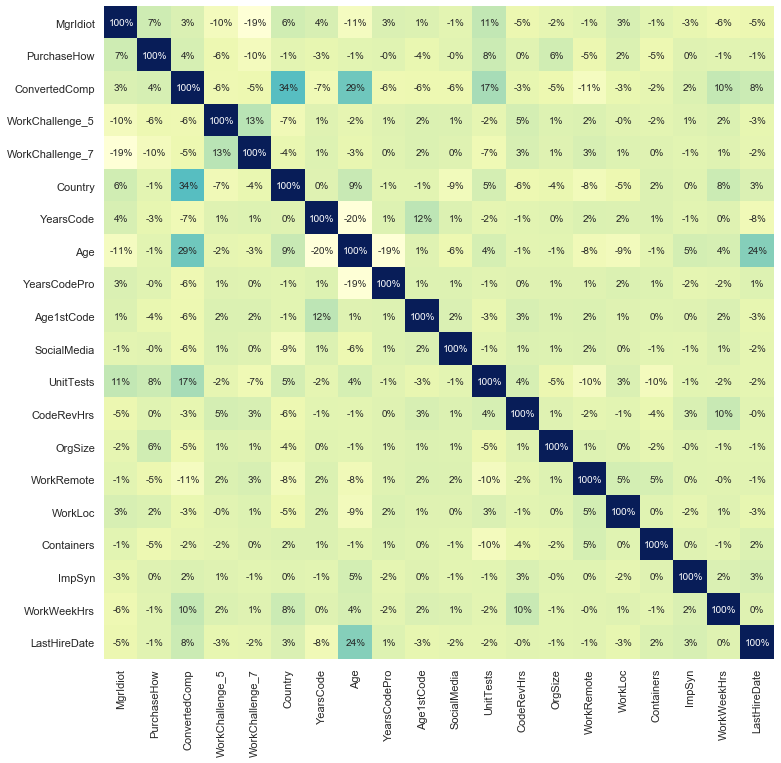

In [369]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
sns.heatmap(scipy.stats.spearmanr(X).correlation,annot=True,fmt='.0%',cmap="YlGnBu",ax=ax,cbar=False,xticklabels=X.columns,yticklabels=X.columns);